## Question 3: Changing Habits (Audiobooks & Genres)

**Approach & Reasoning:**

1.  **Format Evolution (Time-Series):**
    *   **Method:** We tag books as "Audiobook" or "Non-Audiobook" based on the genres list. We then analyze this in two steps:
    1.  **Length Analysis:** We visualize the rise of Audiobooks alongside Average Page Count over the years. We calculate the correlation between them and compare the average length of Audio vs. Non-Audio books.
    2.  **Success Analysis:** We compare the average reach (`num_ratings`) of Audiobooks vs. Non-Audiobooks to see if the format drives popularity.

2.  **Individual Genre Reach:**
    *   *Method:* We will isolate content genres (excluding formats tags like "Audiobook") and calculate the average `num_ratings` for the top 20 most frequent tags.
    *   *Why:* To identify which specific topics (e.g., Fantasy, Thriller) have the highest commercial "ceiling."

3.  **Combination Analysis (Interaction Effects):**
    *   *Method:* We will generate all possible genre combinations and calculate the average reach for each combinations with sufficient sample size ($N \ge 30$).
    *   *Why:* To discover "Force Multipliers" — instances where two genres combined perform significantly better than either genre alone.
    *   *Statistical Test:* We will use **Kruskal-Wallis** and **Mann-Whitney U** tests to prove that the combination effect is statistically significant and not just random noise.

**Expected Outputs:**
*   A dual-axis chart showing the correlation between Audiobook growth and Book Length.
*   A comparison table quantifying the "Audiobook Advantage".
*   Bar charts identifying the highest-reach genre combinations.
*   Statistical p-values confirming the validity of these trends.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress = True, linewidth = 120, edgeitems = 5)
sns.set_theme(style="whitegrid")


In [3]:
dataPath = "../../Data/Raw/parsed_books_data.tsv"

df = pd.read_csv(dataPath, sep = "\t", na_values = ["NA"])

sampleCount, featureCount = df.shape

print(f"Total samples:    {sampleCount}")
print(f"Total features:   {featureCount}")
print("-" * 30)
print("Columns:", df.columns.tolist())

print("-" * 30)
display(df.head())

Total samples:    5283
Total features:   24
------------------------------
Columns: ['price', 'title', 'rating', 'num_ratings', 'num_reviews', 'num_pages', 'genres', 'publication_year', 'author', 'author_book_count', 'author_followers_count', 'five_star_count', 'five_star_percentage', 'four_star_count', 'four_star_percentage', 'three_star_count', 'three_star_percentage', 'two_star_count', 'two_star_percentage', 'one_star_count', 'one_star_percentage', 'votes', 'category', 'award_year']
------------------------------


,price,title,rating,num_ratings,num_reviews,num_pages,genres,publication_year,author,author_book_count,author_followers_count,five_star_count,five_star_percentage,four_star_count,four_star_percentage,three_star_count,three_star_percentage,two_star_count,two_star_percentage,one_star_count,one_star_percentage,votes,category,award_year
0,14.99,The Wedding People,4.16,327019,38667,384.0,Fiction|Romance|Audiobook|Contemporary|Literar...,2024,Alison Espach,8,2416.0,123227,37,144585,44,48565,14,8388,2,2254,0,94733,Fiction,2024
1,14.99,Intermezzo,3.93,171506,31312,454.0,Fiction|Contemporary|Literary Fiction|Romance|...,2024,Sally Rooney,43,61500.0,53605,31,68660,40,36424,21,9842,5,2975,1,67268,Fiction,2024
2,9.13,Welcome to the Hyunam-Dong Bookshop,3.97,49745,9574,307.0,Contemporary|Books About Books|Audiobook|Cozy|...,2022,Hwang Bo-Reum,3,740.0,15568,31,20267,40,11063,22,2367,4,480,0,51958,Fiction,2024
3,13.99,Blue Sisters,3.98,140226,19902,342.0,Fiction|Contemporary|Literary Fiction|Audioboo...,2024,Coco Mellors,5,5253.0,43785,31,60355,43,27337,19,7508,5,1241,0,50659,Fiction,2024
4,14.99,Here One Moment,4.05,146803,16125,512.0,Fiction|Audiobook|Mystery|Contemporary|Thrille...,2024,Liane Moriarty,42,71800.0,49893,33,62470,42,27770,18,5392,3,1278,0,48432,Fiction,2024


### 1. Audiobook
How does **Audiobooks** affect book length?

Pages vs Audiobooks
    award_year  num_pages  is_audiobook  audio_pct
0         2011      335.8      0.295943       29.6
1         2012      336.5      0.336683       33.7
2         2013      349.8      0.412060       41.2
3         2014      337.5      0.446115       44.6
4         2015      336.8      0.483709       48.4
5         2016      333.6      0.530000       53.0
6         2017      336.4      0.634085       63.4
7         2018      338.1      0.672249       67.2
8         2019      336.1      0.626598       62.7
9         2020      329.1      0.669251       66.9
10        2021      344.9      0.707965       70.8
11        2022      344.7      0.697329       69.7
12        2023      391.7      0.812709       81.3
13        2024      367.0      0.806667       80.7


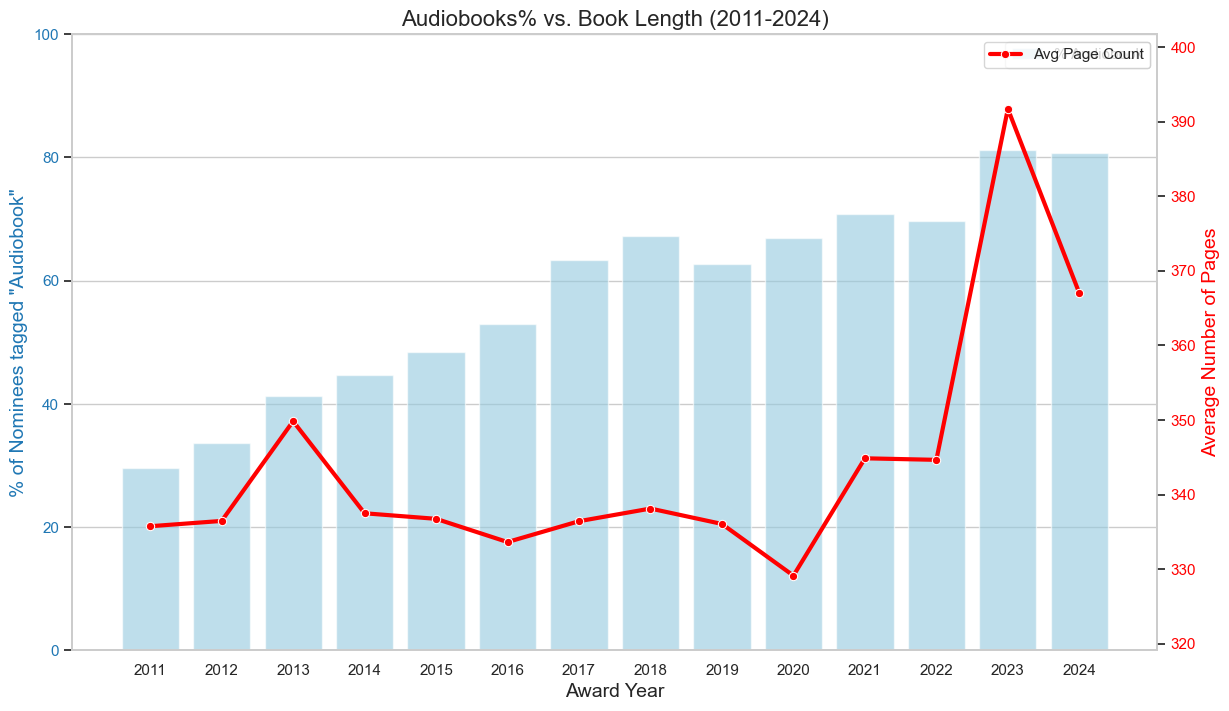

In [4]:
df['is_audiobook'] = df['genres'].fillna('').apply(lambda x: 1 if 'Audiobook' in str(x) else 0)

trends_df = df.groupby('award_year').agg({
    'num_pages': 'mean',          
    'is_audiobook': 'mean'        
}).reset_index()

trends_df['audio_pct'] = trends_df['is_audiobook'] * 100

print("Pages vs Audiobooks")
display_table = trends_df.copy()
display_table['num_pages'] = display_table['num_pages'].round(1)
display_table['audio_pct'] = display_table['audio_pct'].round(1)
print(display_table)

fig, ax1 = plt.subplots(figsize=(14, 8))

sns.barplot(
    x='award_year', 
    y='audio_pct', 
    data=trends_df, 
    color='skyblue', 
    alpha=0.6, 
    ax=ax1,
    label='% Audiobook'
)
ax1.set_ylabel('% of Nominees tagged "Audiobook"', color='tab:blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Award Year', fontsize=14)

ax2 = ax1.twinx()

sns.lineplot(
    x=range(len(trends_df)), 
    y='num_pages', 
    data=trends_df, 
    color='red', 
    marker='o', 
    linewidth=3, 
    ax=ax2,
    label='Avg Page Count'
)
ax2.set_ylabel('Average Number of Pages', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')
min_page = trends_df['num_pages'].min() - 10
max_page = trends_df['num_pages'].max() + 10
ax2.set_ylim(min_page, max_page)

plt.title('Audiobooks% vs. Book Length (2011-2024)', fontsize=16)
plt.grid(False) 

plt.show()

#### Observation:
*   The popularity of audiobooks has increased significantly over the years. In 2011, only about 30% of award-nominated books were available as audiobooks, but by 2024, that number was over 80%. 

*   The average book increased slightly from about 335 pages in 2011 to 370 pages in 2024.

*   **Hypothesis:** Audiobooks make it easier for people to enjoy longer stories while doing other things so books are getting longer.

In [14]:
corr_pages_audio = df[['num_pages', 'is_audiobook']].dropna().corr().iloc[0, 1]

print(f"Correlation between Page Num and Is_Audiobook: {corr_pages_audio:.4f}")

avg_len_audio = df[df['is_audiobook'] == 1]['num_pages'].mean()
avg_len_physical = df[df['is_audiobook'] == 0]['num_pages'].mean()

print(f"Average Length - Audiobook:    {avg_len_audio:.0f} pages")
print(f"Average Length - No Audiobook: {avg_len_physical:.0f} pages")

Correlation between Page Num and Is_Audiobook: 0.1833
Average Length - Audiobook:    366 pages
Average Length - No Audiobook: 312 pages


In [13]:
pages_audio = df[df['is_audiobook'] == 1]['num_pages'].dropna()
pages_no_audio = df[df['is_audiobook'] == 0]['num_pages'].dropna()

t_stat_pages, p_val_pages = stats.ttest_ind(pages_audio, pages_no_audio, equal_var=False, alternative='greater')

print(f"Difference in length: {pages_audio.mean() - pages_no_audio.mean():.1f} pages")
print(f"P-value for length difference: {p_val_pages:.4e}")

Difference in length: 53.5 pages
P-value for length difference: 1.9691e-38


#### Conclusion:
*   **Statistical Confirmation:** The T-Test returns a near zero p-value ($1.97 \times 10^{-38}$), proving that books with an **Audiobook** format are statistically longer than those without.
*   On average, audiobooks are **53.5 pages longer** than non-audiobooks. 
*   **Insight:** This confirms that the Audiobook format is a key factor in making books longer.

Is **Audiobook** an important driver for a book's success? 


Audio vs. No Audio
-----------------------------------------------------------------
          Format  count          mean  median
No Audiobook Tag   2280  81146.665351 12610.5
Audiobook Tagged   3003 125606.173493 38841.0
-----------------------------------------------------------------
Insight: Audiobooks have 1.55x the average ratings of non-audiobooks.


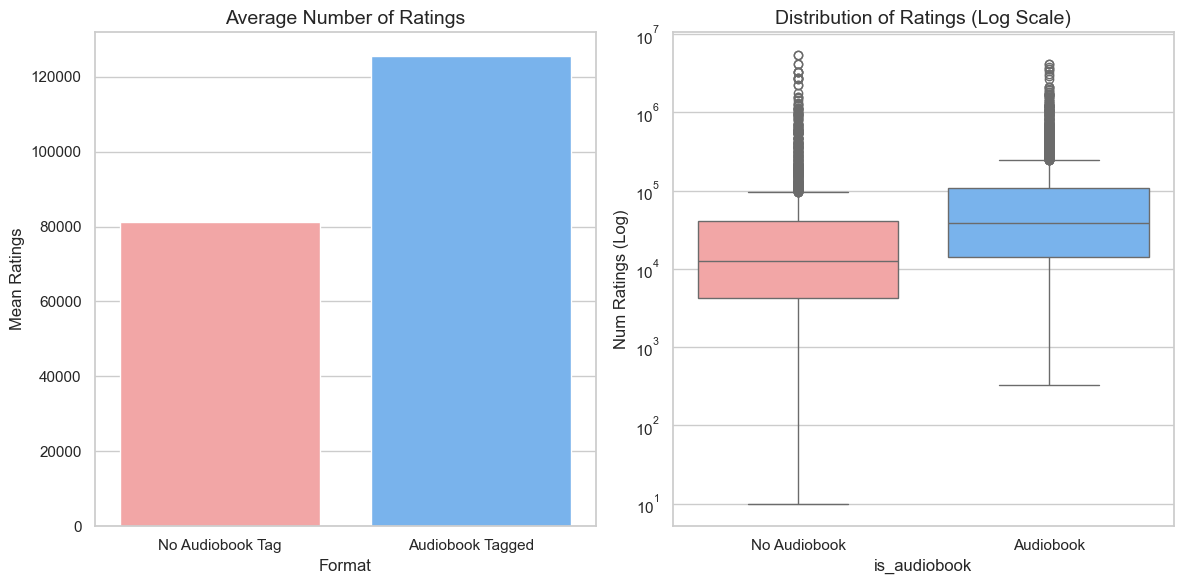

In [6]:
audio_comparison = df.groupby('is_audiobook')['num_ratings'].agg(['mean', 'median', 'count']).reset_index()
audio_comparison['Format'] = audio_comparison['is_audiobook'].map({1: 'Audiobook Tagged', 0: 'No Audiobook Tag'})

print("\nAudio vs. No Audio")
print("-" * 65)
print(audio_comparison[['Format', 'count', 'mean', 'median']].to_string(index=False))
print("-" * 65)

multiplier = audio_comparison.loc[1, 'mean'] / audio_comparison.loc[0, 'mean']
print(f"Insight: Audiobooks have {multiplier:.2f}x the average ratings of non-audiobooks.")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(
    x='Format', 
    y='mean', 
    data=audio_comparison, 
    palette=['#ff9999','#66b3ff'], 
    hue = 'Format', 
    legend=False
)

plt.title('Average Number of Ratings', fontsize=14)
plt.ylabel('Mean Ratings')

plt.subplot(1, 2, 2)
sns.boxplot(
    x='is_audiobook', 
    y='num_ratings', 
    data=df, palette=['#ff9999','#66b3ff'], 
    hue = 'is_audiobook', 
    legend=False

)
plt.yscale('log') 
plt.title('Distribution of Ratings (Log Scale)', fontsize=14)
plt.xticks([0, 1], ['No Audiobook', 'Audiobook'])
plt.ylabel('Num Ratings (Log)')

plt.tight_layout()
plt.show()

#### Observation: 
*   Books with Audiobook tag has higher average ratings than books without Audiobook tag

In [7]:
group_audio = df[df['is_audiobook'] == 1]['num_ratings']
group_no_audio = df[df['is_audiobook'] == 0]['num_ratings']

t_stat, p_val_t = stats.ttest_ind(group_audio, group_no_audio, equal_var=False, alternative='greater')

print("T-Test: Audio vs. Non-Audio Avg Num Ratings")
print("-" * 60)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_val_t:.4e}")
print("alpha:       0.05")
print("-" * 60)

alpha = 0.05
if p_val_t < alpha:
    print("Result: Reject H0")
    print("Conclusion: There is a statistically significant difference")
    print("Books tagged as 'Audiobook' have a significantly higher average reach than those without")
else:
    print("Result: Fail to Reject H0")
    print("The observed difference in means might be due to random chance")

T-Test: Audio vs. Non-Audio Avg Num Ratings
------------------------------------------------------------
T-statistic: 5.1487
P-value:     1.3652e-07
alpha:       0.05
------------------------------------------------------------
Result: Reject H0
Conclusion: There is a statistically significant difference
Books tagged as 'Audiobook' have a significantly higher average reach than those without


#### Conclusion: 
The statistical test confirms that the difference in reach is real. Books with an **Audiobook** format have a significant competitive advantage in reaching a wider audience (~x1.5 times visibility).

For authors and publishers, this means that having audio is an important driver of higher engagement and commercial success.

### 2. Other genres

Which **Genres, Genre Combinations** are most popular? Is there a benefit to combining multiple genres?

Top 20 genres


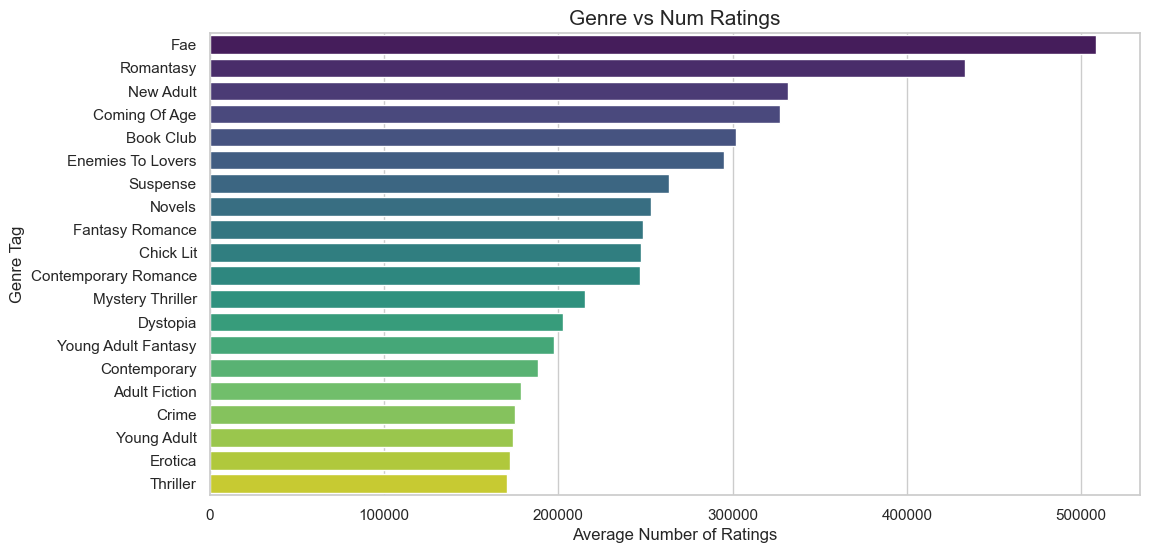

In [8]:
df['genres_list'] = df['genres'].fillna('').str.split('|')
df['genres_list'] = df['genres_list'].apply(lambda x: [g for g in x if g != 'Audiobook'])

genre_exploded = df.explode('genres_list')

genre_num_ratings = genre_exploded.groupby('genres_list').agg(
    avg_reach=('num_ratings', 'mean'),
    book_count=('num_ratings', 'count')
).reset_index()

significant_genres = genre_num_ratings[genre_num_ratings['book_count'] >= 50]
top_20_reach = significant_genres.sort_values(by='avg_reach', ascending=False).head(20)

print("Top 20 genres")

plt.figure(figsize=(12, 6))
sns.barplot(
    x='avg_reach', 
    y='genres_list', 
    data=top_20_reach, 
    palette='viridis', 
    hue='genres_list', 
    legend=False
)

plt.title('Genre vs Num Ratings', fontsize=15)
plt.xlabel('Average Number of Ratings')
plt.ylabel('Genre Tag')
plt.show()

#### Observation: 

*   Combinations of genres perform significantly better than individual genres alone

*   While the top individual genre ("Fae") averages about 500,000 ratings, the top combination ("Fae + Romantasy") has nearly 800,000 ratings. This suggests a "Force Multiplier" effect: specific pairings result in significantly higher popularity.

Top 15 genre combinations


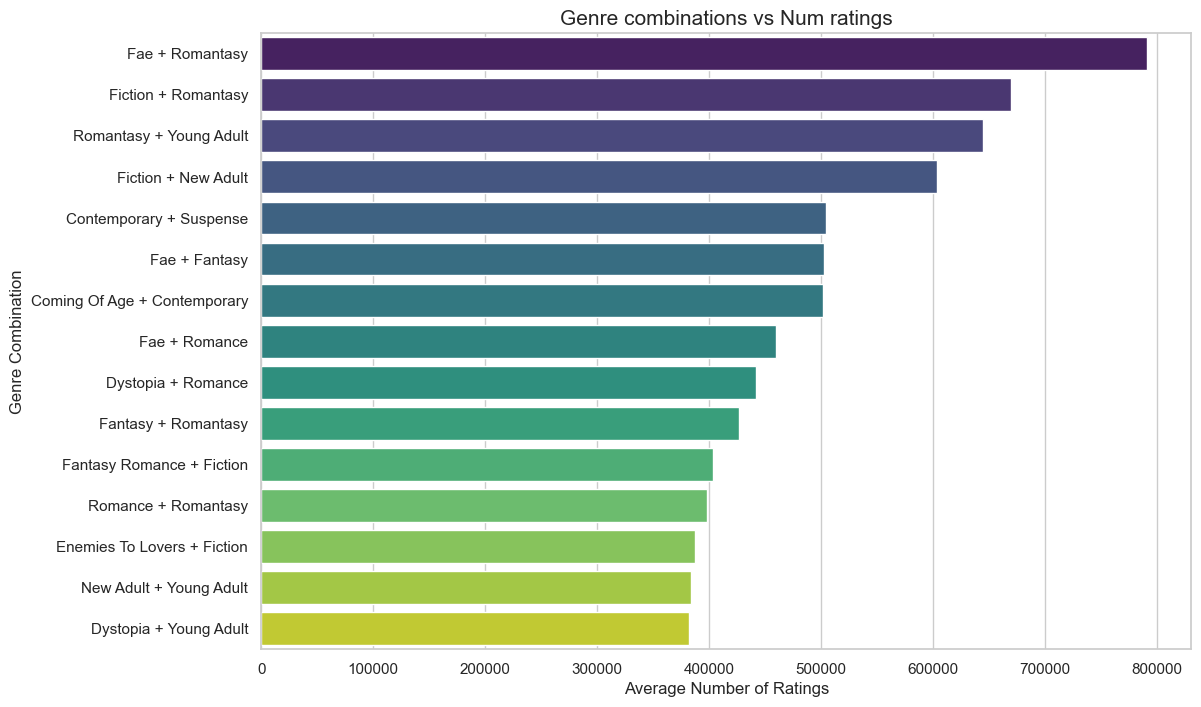

In [9]:
all_pairs = []
for genre_list in df['genres_list']:
    clean_list = [g for g in genre_list if g]
    if len(clean_list) > 1:
        for pair in combinations(sorted(clean_list), 2):
            all_pairs.append(pair)

pair_counts = Counter(all_pairs)
common_pairs = [pair for pair, count in pair_counts.items() if count >= 30]

pair_reach_data = []
for pair in common_pairs:
    mask = df['genres'].str.contains(pair[0]) & df['genres'].str.contains(pair[1])
    avg_reach = df[mask]['num_ratings'].mean()
    pair_reach_data.append({
        'Pair': f"{pair[0]} + {pair[1]}",
        'avg_reach': avg_reach,
        'count': pair_counts[pair]
    })

pair_reach_df = pd.DataFrame(pair_reach_data).sort_values(by='avg_reach', ascending=False)

print("Top 15 genre combinations")

plt.figure(figsize=(12, 8))
sns.barplot(
    x='avg_reach', 
    y='Pair', 
    data=pair_reach_df.head(15), 
    palette='viridis', 
    hue='Pair', 
    legend=False
)
plt.title('Genre combinations vs Num ratings', fontsize=15)
plt.xlabel('Average Number of Ratings')
plt.ylabel('Genre Combination')
plt.show()

In [10]:
pairs = [
    ('Fae', 'Romantasy'),
    ('Fiction', 'Romantasy'),
    ('Fiction', 'New Adult'),
    ('Audiobook', 'New Adult')
]

print("Single genres vs genre combinations")

for tag_a, tag_b in pairs:
    print(f"\nCombination: [{tag_a} + {tag_b}]")
    
    has_a = df['genres'].fillna('').str.contains(tag_a)
    has_b = df['genres'].fillna('').str.contains(tag_b)
    
    group_a_only = df[has_a & ~has_b]['num_ratings']
    group_b_only = df[has_b & ~has_a]['num_ratings']
    group_both   = df[has_a & has_b]['num_ratings']
    
    print(f"Sample Sizes -> {tag_a} Only: {len(group_a_only)} | {tag_b} Only: {len(group_b_only)} | Both: {len(group_both)}")
    
    h_stat, p_kruskal = stats.kruskal(group_a_only, group_b_only, group_both)
    print(f"Kruskal-Wallis p-value: {p_kruskal:.4e}")
    
    _, p_mw_a = stats.mannwhitneyu(group_both, group_a_only, alternative='greater')
    _, p_mw_b = stats.mannwhitneyu(group_both, group_b_only, alternative='greater')
    
    print(f"Mann-Whitney (Both > {tag_a}): {p_mw_a:.4e}")
    print(f"Mann-Whitney (Both > {tag_b}): {p_mw_b:.4e}")
    
    if p_mw_a < 0.05 and p_mw_b < 0.05:
        print(f"-> Genre combination [{tag_a}+{tag_b}] outperforms both individual genres.")
    elif p_mw_a < 0.05 or p_mw_b < 0.05:
            print(f"-> Genre combination [{tag_a}+{tag_b}] outperforms one component, but not both.")
    else:
        print(f"-> The combination [{tag_a}+{tag_b}] is not statistically superior.")
        
    print("-" * 60)

Single genres vs genre combinations

Combination: [Fae + Romantasy]
Sample Sizes -> Fae Only: 24 | Romantasy Only: 60 | Both: 30
Kruskal-Wallis p-value: 2.6441e-03
Mann-Whitney (Both > Fae): 7.9017e-04
Mann-Whitney (Both > Romantasy): 3.8358e-03
-> Genre combination [Fae+Romantasy] outperforms both individual genres.
------------------------------------------------------------

Combination: [Fiction + Romantasy]
Sample Sizes -> Fiction Only: 3257 | Romantasy Only: 37 | Both: 53
Kruskal-Wallis p-value: 2.3984e-10
Mann-Whitney (Both > Fiction): 5.3358e-11
Mann-Whitney (Both > Romantasy): 7.5764e-05
-> Genre combination [Fiction+Romantasy] outperforms both individual genres.
------------------------------------------------------------

Combination: [Fiction + New Adult]
Sample Sizes -> Fiction Only: 3239 | New Adult Only: 82 | Both: 71
Kruskal-Wallis p-value: 2.2655e-09
Mann-Whitney (Both > Fiction): 7.9789e-10
Mann-Whitney (Both > New Adult): 7.4726e-05
-> Genre combination [Fiction+New 

#### Conclusion: 
*   Readers prefer certain genres like "Fae" and "Romantasy". Additionally, combining certain genres will result in higher reach for a book.